# DDW TASK 2

## Contribution
- Jia Hui - Brainstormed on features, researching, model experimenting
- Pei Xuan - Brainstormed on features, researching, data cleaning
- Min Khant - Brainstormed on features, researching

## Problem Statement

We aim to predict the number of Hospital Admissions in United Kingdom using:

1. Number of days from the introduction of Delta variant
2. Vaccination Rate 

## Discussion on Predictors

The prediction of hospital admissions could increase the readiness of health care workers and hospital supplies to effectively deal with the surge in patients.

As Delta Variant is more contagious than original coronavirus, it would increase Hospital Admissions in United Kingdom. \
Higher vaccination rates might slow down the spreading of the virus which might reduce Hospital Admissions.


## Link to Data Sources
### 
- [Hospital Admissions](https://coronavirus.data.gov.uk/details/healthcare)

- [Vaccination Rate](https://coronavirus.data.gov.uk/details/vaccinations)

## Cleaning of Data

1. Took data from 1/6/2021 to 8/11/2021
2. Remove outliers
3. Checked for duplicates
4. Checked for empty cells
5. Arrange data according to date

## All possible models
1. **[Linear Regression](#linear)**
2. **[Polynomial Regression](#poly)**
1. **[Mutiple Regression](#multi)**

## Required Imports

In [223]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

## Functions

In [224]:
def normalize_z(df):
    # mean with axis 0 is summing the rows
    return (df - df.mean(axis=0)) / df.std(axis=0) 

def get_features_targets(df, feature_names, target_names):
    df_feature = df[feature_names]
    df_target = df[target_names]
    return df_feature, df_target

def prepare_feature(df_feature):
    cols = len(df_feature.columns) 
    feature = df_feature.to_numpy()
    number_of_samples = feature.shape[0]
    return np.concatenate((np.ones((number_of_samples,1)), feature), axis=1)

def prepare_target(df_target):
    # to_numpy() removes the first column (header column)
    return df_target.to_numpy()

def predict(df_feature, beta):
    X = prepare_feature(normalize_z(df_feature))
    return predict_norm(X, beta)

def predict_norm(X, beta):
    return np.matmul(X,beta)

def split_data(df_feature, df_target, random_state=100, test_size=0.3):
    # get the indexes of the feature 
    indexes = df_feature.index
    # seed the random value 
    if random_state != None:
        np.random.seed(random_state)
    # get the number of test samples to extract 
    k = int(test_size * len(indexes))
    # get the indexes from the features and target to select as test set 
    test_index = np.random.choice(indexes, k, replace=False)
    indexes = set(indexes)
    test_index = set(test_index)
    train_index = indexes - test_index
    df_feature_train = df_feature.loc[train_index, :]
    df_feature_test = df_feature.loc[test_index, :]
    df_target_train = df_target.loc[train_index, :]
    df_target_test = df_target.loc[test_index, :]
    return df_feature_train, df_feature_test, df_target_train, df_target_test
  
  
def r2_score(y, ypred):
    sum_res = np.sum((y - ypred)**2)
    error_tot = y - np.mean(y)
    sum_tot = np.sum(error_tot**2)
    return 1-(sum_res/sum_tot)

def adjusted_r2_score(y, ypred, p):
    r2 = r2_score(y, ypred)
    N = y.shape[0]
    return 1-((1-r2)*(N-1)/(N-p-1))

def mean_squared_error(target, pred):
    n = target.shape[0]
    return 1/n * np.sum((target-pred)**2)

def compute_cost(X, y, beta):
    J = 0
    no_of_samples = X.shape[0]
    error = np.matmul(X, beta) - y
    error_sq = np.matmul(error.T, error) # .T is transpose
    J = 1/(2*no_of_samples) * error_sq
    return J[0][0]

def gradient_descent(X, y, beta, alpha, num_iters):
    number_of_samples = X.shape[0]
    J_storage = []
    for i in range(num_iters):
        # STEP 2: compute the derivate with current parameters
        derivative_error = (1/(number_of_samples)) * np.matmul(X.T, (np.matmul(X, beta) - y))
        # STEP 3: update the parameters
        beta = beta - alpha *  derivative_error
        # compute cost at every iteration of beta
        J_storage.append(compute_cost(X, y, beta))
    return beta, J_storage

def transform_features_power(df_feature, colname, colname_transformed, value):
    copy = df_feature.copy()
    copy.loc[:, colname_transformed] = df_feature.loc[:,colname] ** value 
    return copy

def printBeta(beta):
    stringDisplay = "The beta values are "
    for i in range(beta.shape[0]):
        if i == beta.shape[0]-1:
            stringDisplay += str(round(beta[i][0], 2)) + "."
            break
        stringDisplay += str(round(beta[i][0], 2)) + ", "
    print(stringDisplay) 

## Reading data from CSV

Text(0.5, 0, 'Delta')

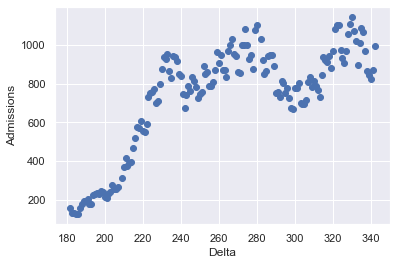

In [225]:
import matplotlib.dates as mdates
df = pd.read_csv("DDW_dataset1.csv")

sns.set()
df_feature_delta, df_target = get_features_targets(df,["Delta"],["Admissions"])
plt.scatter(df_feature_delta, df_target)
plt.ylabel("Admissions")
plt.xlabel("Delta")

Text(0.5, 0, 'Vaccination')

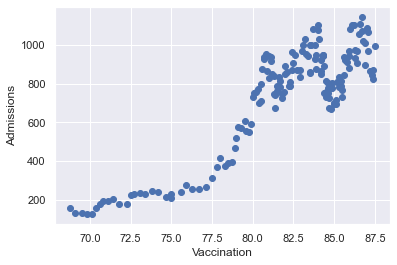

In [226]:
df_feature_vaccination, df_target = get_features_targets(df,["Vaccination"],["Admissions"])
plt.scatter(df_feature_vaccination, df_target)
plt.ylabel("Admissions")
plt.xlabel("Vaccination")

## Discussion on the Shape of Data

Delta : From the graph, we can see that the number of hospital admissions spike up to around ~990 after about 235 days from the introduction of the Delta Variant.


## ===== **Linear Regression** =====
<a id="linear"></a>

## ->Delta

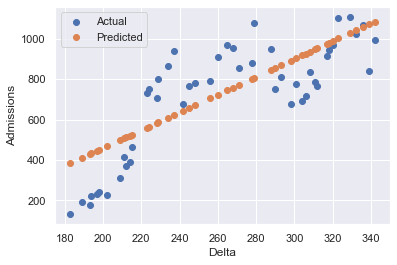

In [227]:
# Delta
df_features_train, df_features_test, df_target_train, df_target_test = split_data(df_feature_delta, df_target)

# normalize features
df_features_train_z = normalize_z(df_features_train)

# change to numpy array and append column for feature
X = prepare_feature(df_features_train_z)
target = prepare_target(df_target_train)

iterations = 1500
alpha = 0.01
beta = np.zeros((2,1))

# call gradient_descent() function
beta, J_storage = gradient_descent(X, target, beta, alpha, iterations)

pred = predict(df_features_test, beta)

plt.scatter(df_features_test["Delta"], df_target_test, label="Actual")
plt.scatter(df_features_test["Delta"], pred, label="Predicted")
plt.ylabel("Admissions")
plt.xlabel("Delta")
plt.legend()

In [228]:
# TESTS
printBeta(beta)
target = prepare_target(df_target_test)

a_r2 = adjusted_r2_score(target, pred, 2)
print("The Adjusted R Squared value is", round(a_r2, 2))


The beta values are 737.33, 215.72.
The Adjusted R Squared value is 0.63


## ->Vaccination

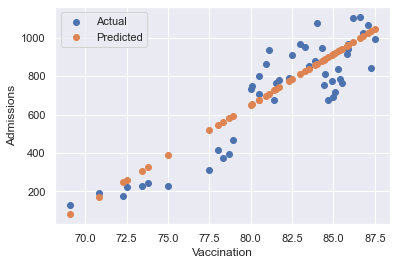

In [229]:
# Transit
df_features_train, df_features_test, df_target_train, df_target_test = split_data(df_feature_vaccination, df_target)

# normalize features
df_features_train_z = normalize_z(df_features_train)

# change to numpy array and append column for feature
X = prepare_feature(df_features_train_z)
target = prepare_target(df_target_train)

iterations = 1500
alpha = 0.01
beta = np.zeros((2,1))

# call gradient_descent() function
beta, J_storage = gradient_descent(X, target, beta, alpha, iterations)

pred = predict(df_features_test, beta)

plt.scatter(df_features_test["Vaccination"], df_target_test, label="Actual")
plt.scatter(df_features_test["Vaccination"], pred, label="Predicted")
plt.ylabel("Admissions")
plt.xlabel("Vaccination")
plt.legend()

In [230]:
# TESTS
printBeta(beta)
target = prepare_target(df_target_test)

a_r2 = adjusted_r2_score(target, pred, 2)
print("The Adjusted R Squared value is", round(a_r2, 2))


The beta values are 737.33, 248.83.
The Adjusted R Squared value is 0.79


## ==== **Polynomial Linear Regression** ====
<a id="poly"></a>

## ->Delta

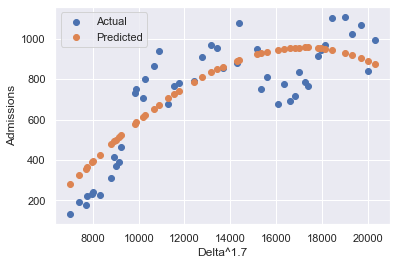

In [231]:
df_features_second = transform_features_power(df_feature_delta, 'Delta', 'Delta^1.7', 1.7)
df_features_second = transform_features_power(df_features_second, 'Delta', 'Delta^5', 5.5)
df_features_second = transform_features_power(df_features_second, 'Delta', 'Delta^6', 6)


# print(df_features_second)

df_features_train, df_features_test, df_target_train, df_target_test = split_data(df_features_second, df_target)

# normalize features
df_features_train_z = normalize_z(df_features_train)

# change to numpy array and append column for feature
X = prepare_feature(df_features_train_z)
target = prepare_target(df_target_train)

iterations = 1500
alpha = 0.01
beta = np.zeros((5,1))

# call gradient_descent() function
beta, J_storage = gradient_descent(X, target, beta, alpha, iterations)

pred = predict(df_features_test, beta)

plt.scatter(df_features_test["Delta^1.7"], df_target_test, label="Actual")
plt.scatter(df_features_test["Delta^1.7"], pred, label="Predicted")
plt.ylabel("Admissions")
plt.xlabel("Delta^1.7")
plt.legend()


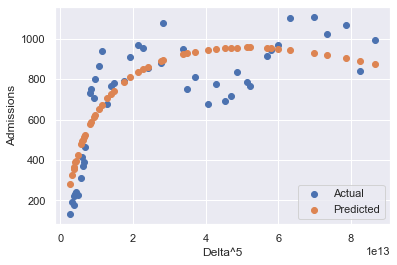

In [232]:
plt.scatter(df_features_test["Delta^5"], df_target_test, label="Actual")
plt.scatter(df_features_test["Delta^5"], pred, label="Predicted")
plt.ylabel("Admissions")
plt.xlabel("Delta^5")
plt.legend()

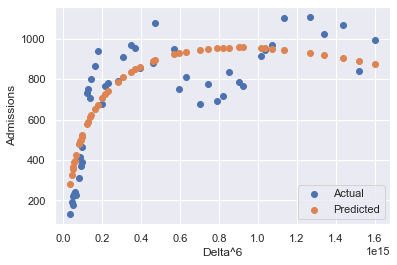

In [233]:
plt.scatter(df_features_test["Delta^6"], df_target_test, label="Actual")
plt.scatter(df_features_test["Delta^6"], pred, label="Predicted")
plt.ylabel("Admissions")
plt.xlabel("Delta^6")
plt.legend()

In [234]:
# TESTS
printBeta(beta)
target = prepare_target(df_target_test)

a_r2 = adjusted_r2_score(target, pred, 4)
print("The Adjusted R Squared value is", round(a_r2, 2))

# 0.707 , 1.7, 5.5, 6

The beta values are 737.33, 272.52, 192.69, -123.31, -148.75.
The Adjusted R Squared value is 0.7


## ->Vaccination

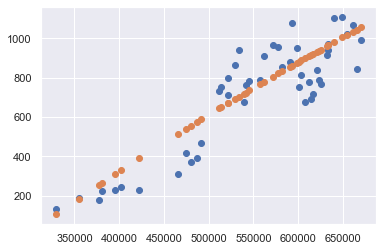

In [235]:
df_features_second = transform_features_power(df_feature_vaccination, 'Vaccination', 'Vaccination^2', 2)
df_features_second = transform_features_power(df_features_second, 'Vaccination', 'Vaccination^3', 3)

# print(df_features_second)

df_features_train, df_features_test, df_target_train, df_target_test = split_data(df_features_second, df_target)

# normalize features
df_features_train_z = normalize_z(df_features_train)

# change to numpy array and append column for feature
X = prepare_feature(df_features_train_z)
target = prepare_target(df_target_train)

iterations = 1500
alpha = 0.01
beta = np.zeros((4,1))

# call gradient_descent() function
beta, J_storage = gradient_descent(X, target, beta, alpha, iterations)

pred = predict(df_features_test, beta)

plt.scatter(df_features_test["Vaccination^3"], df_target_test)
plt.scatter(df_features_test["Vaccination^3"], pred)


In [236]:
# TESTS
printBeta(beta)
target = prepare_target(df_target_test)

a_r2 = adjusted_r2_score(target, pred, 3)
print("The Adjusted R Squared value is", round(a_r2, 2))

The beta values are 737.33, 98.74, 83.02, 66.19.
The Adjusted R Squared value is 0.78


## ==== **Multiple Linear Regression** ====
<a id="multi"></a>

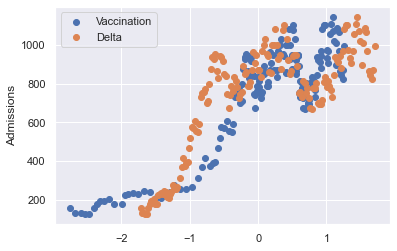

In [237]:
df_features, df_target = get_features_targets(df,["Vaccination", "Delta"],["Admissions"])

df_features = normalize_z(df_features)

plt.scatter(df_features["Vaccination"], df_target, label="Vaccination")
plt.scatter(df_features["Delta"], df_target, label="Delta")
plt.ylabel("Admissions")
plt.legend()


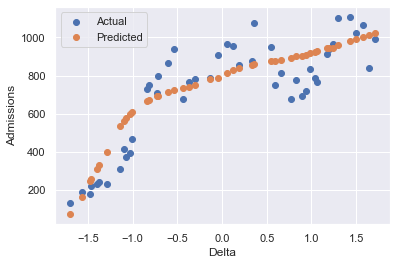

In [238]:
df_features_train, df_features_test, df_target_train, df_target_test = split_data(df_features, df_target)

# normalize features
df_features_train_z = normalize_z(df_features_train)

# change to numpy array and append column for feature
X = prepare_feature(df_features_train_z)
target = prepare_target(df_target_train)

iterations = 1500
alpha = 0.01
beta = np.zeros((3,1))

# call gradient_descent() function
beta, J_storage = gradient_descent(X, target, beta, alpha, iterations)

pred = predict(df_features_test, beta)

plt.scatter(df_features_test["Delta"], df_target_test, label="Actual")
plt.scatter(df_features_test["Delta"], pred, label="Predicted")
plt.ylabel("Admissions")
plt.xlabel("Delta")
plt.legend()

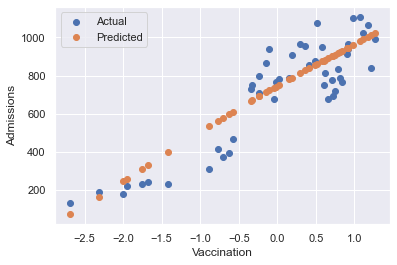

In [239]:
plt.scatter(df_features_test["Vaccination"], df_target_test, label="Actual")
plt.scatter(df_features_test["Vaccination"], pred, label="Predicted")
plt.ylabel("Admissions")
plt.xlabel("Vaccination")
plt.legend()

In [240]:
# TESTS
printBeta(beta)
target = prepare_target(df_target_test)

a_r2 = adjusted_r2_score(target, pred, 2)
print("The Adjusted R Squared value is", round(a_r2, 2))

The beta values are 737.33, 271.29, -30.3.
The Adjusted R Squared value is 0.79


## Model Evaluation

Steps taken to improve accuracy of model
1. Logging features
2. Adjusting the power of polynomial linear regression model
3. Removing outliers
4. Research for other possible features:<br/>
    i) Number of Covid Tests Daily<br/> 
    ii) Measurement of visitors to Transit Areas
5. Calculating R Squared value for target and individual features to ensure there is correlation


## Discussion on Models

